# Aplicação de Python na Agrometeorologia

Este Jupyter Notebook é parte integrande do curso de Python ministrado durante XXII Congresso Brasiliero de Agrometeorologia realizado nos dias 3, 4 e 5 de outubro de 2023 na cidade Natal/RN.

# Importação de bibliotecas

In [42]:
import xarray as xr
import regionmask
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Abertura do arquivo no formato NetCDF (Network Common Data Form)

In [43]:
# Diretório dos arquivos.
DIRETORIO_DADOS = '../input/precipitacao/CPC'

# Abertura do arquivo.
ds = xr.open_mfdataset(f'{DIRETORIO_DADOS}/precip.????.nc')

# Importação de variáveis.
prec = ds['precip']
lat = ds['lat']
lon = ds['lon']

Inspecionando a variável **prec**.

In [44]:
prec

<xarray.DataArray 'precip' (time: 11688, lat: 31, lon: 22)>
dask.array<concatenate, shape=(11688, 31, 22), dtype=float32, chunksize=(366, 31, 22), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2022-12-31
  * lon      (lon) float32 -44.75 -44.25 -43.75 -43.25 ... -35.25 -34.75 -34.25
  * lat      (lat) float32 -2.25 -2.75 -3.25 -3.75 ... -16.25 -16.75 -17.25
Attributes:
    long_name:     Daily total of precipitation
    units:         mm
    var_desc:      Precipitation
    level_desc:    Surface
    statistic:     Total
    parent_stat:   Other
    cell_methods:  time: sum
    avg_period:    0000-00-01 00:00:00
    actual_range:  [  0.     970.5962]
    dataset:       CPC Global Precipitation

Plot básico da variável prec.

* IPC: O valor **-1** em **prec[-1,:,:].plot()** representa o último tempo do arquivo.

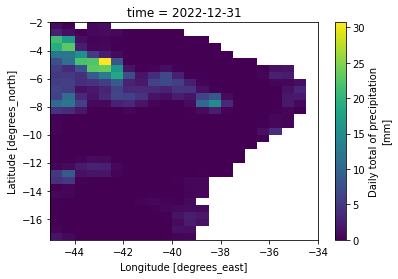

In [45]:
prec[-1,:,:].plot()

# Abertura do arquivo shapefile

In [46]:
# Nome do arquivo shapefile.
Nome_Arquivo_Shapefile = '../input/shapefile/caatinga_contorno/caatinga.shp'

# Leitura do arquivo shapefile utilizando a biblioteca geopandas (gpd).
gdf = gpd.read_file(Nome_Arquivo_Shapefile)

Inspecionando o conteúdo do GeoDataFrame.

In [47]:
gdf

,gid,nome,shape_area,shape_len,geometry
0,1,Caatinga,67.971323,72.915234,"POLYGON ((-40.49531 -2.78574, -40.49173 -2.788..."


Acessando os valores de latitude e longitude que formam o contorno do shapefile.

In [48]:
gdf.geometry.values

<GeometryArray>
[<POLYGON ((-40.495 -2.786, -40.492 -2.788, -40.484 -2.792, -40.48 -2.794, -4...>]
Length: 1, dtype: geometry

Plot básico do arquivo shapefile.

<AxesSubplot:>

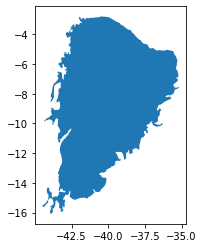

In [49]:
gdf.plot()

# Criação da máscara para aplicar na variável de interesse

In [50]:
# Documentação:
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions.html

# Domínio espacial do arquivo shapefile.
dominio_shapefile = regionmask.Regions(
    outlines=gdf.geometry.values,
    numbers=[0],
    names={0:'Bioma Caatinga'},
    abbrevs={0:'Caatinga'},
    name='Bioma_Caatinga', 
)

dominio_shapefile

<regionmask.Regions 'Bioma_Caatinga'>
overlap:  False

Regions:
0 Caatinga Bioma Caatinga

[1 regions]

In [51]:
# Documentação:
# https://regionmask.readthedocs.io/en/stable/generated/regionmask.Regions.mask.html#regionmask.Regions.mask

# Cria a máscara que será aplicada na variável de interesse.
mascara = dominio_shapefile.mask(
    lon_or_obj=lon,
    lat=lat,
)

Plot básico da máscara. 

**NÃO É A VARIÁVEL A SER UTILIZADA!**

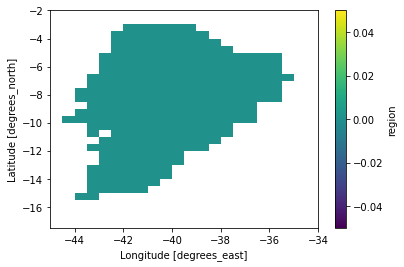

In [52]:
mascara.plot()

Aplica a  máscara na variável de interesse.

In [53]:
dado_mascarado = prec.where(mascara == mascara)

Plot básico para ver a variável mascadara juntamente com o shapefile.

<ipython-input-54-41ed3b993f52>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(


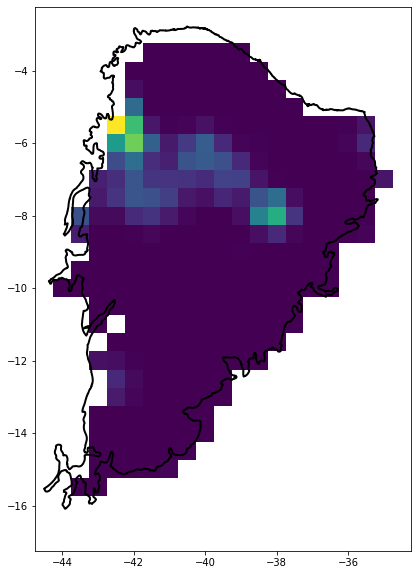

In [54]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot do último tempo (dia) da variável mascarada.
# dado_mascarado[-1,:,:] -> -1 representa o último tempo do arquivo.

plt.pcolormesh(
    dado_mascarado.lon, 
    dado_mascarado.lat, 
    dado_mascarado[-1,:,:]
)

# Sobreposição do shapefile com o dado mascaradado.
gdf.plot(
    ax=plt.gca(), 
    color='none', 
    edgecolor='black', 
    linewidth=2
)

# Salva a figura.
plt.savefig(
    'dado_mascarado.png',
    pad_inches=0.1,
    dpi=300,
    bbox_inches='tight'
)

# Cálculo da média espacial

É feita a média de todos os pontos de grade de latitude e de longitude. O resultado final é uma série temporal diária
do Bioma Caatinga desde 01/01/1991 a 31/12/22.

In [55]:
# Os nomes 'lat' e 'lon fazem parte do seu arquivo.
media_area = dado_mascarado.mean(dim=('lat', 'lon'))

In [56]:
media_area

<xarray.DataArray 'precip' (time: 11688)>
dask.array<mean_agg-aggregate, shape=(11688,), dtype=float32, chunksize=(366,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1991-01-01 1991-01-02 ... 2022-12-31

Plot básico de todos os tempos (dias) da variável 'media_area'.

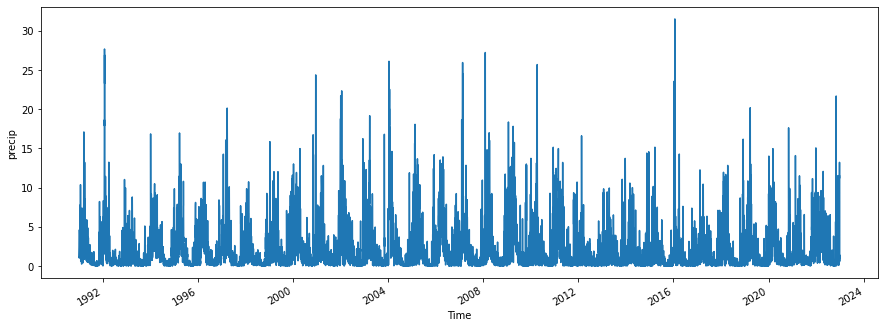

In [57]:
media_area.plot(figsize=(15, 5))

# Criação do DataFrame para armazenar a variável

Os **DataFrames** são objetos bidimensionais, de tamanho variável. 

O seu formato é de uma tabela, onde os dados são organizados em linhas e colunas. 

Além disso, enquanto podemos pensar a **Series** como uma única coluna, o DataFrame seria uma união de várias Series sob um mesmo index.

In [58]:
# Documentação:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

# Cria o DataFrame.
df = pd.DataFrame(data=media_area, index=prec.time, columns=['Chuva'])

# Define o nome do index como 'Dia'.
df.index.name = 'Dia'

In [59]:
df

,Chuva
Dia,
1991-01-01,1.083005
1991-01-02,1.132334
1991-01-03,1.101605
1991-01-04,1.662441
1991-01-05,1.765939
...,...
2022-12-27,0.583862
2022-12-28,0.579153
2022-12-29,1.396807


Estatística básica sobre os dados.

In [60]:
df.describe()

,Chuva
count,11687.000000
mean,1.942385
std,2.798179
min,0.000000
25%,0.260504
50%,0.857347
75%,2.442850
max,31.495855


## Salva o DataFrame em um arquivo no formato csv (Comma-separated values)

In [61]:
df.to_csv(
    '../output/chuva_diaria_cpc_19910901_20221231.csv', 
    sep=',', 
    header=True
)